In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [88]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [89]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [90]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [91]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [92]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

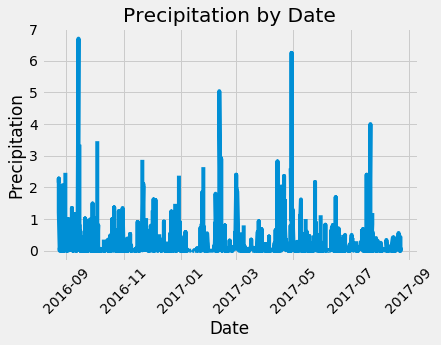

In [123]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
y, m, d = [int(item) for item in query[0].split("-")]
cutoff = dt.datetime(y-1, m, d)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
twelve_months = session.query(*sel).filter(func.strftime(sel[0]) >= cutoff).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(twelve_months, columns = ['date', 'prcp'])
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace = True)

# Sort the dataframe by date
weather_df.sort_values(by=['date'], inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(weather_df['prcp'])
plt.title('Precipitation by Date')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [94]:
# Use Pandas to calculate the summary statistics for the precipitation data
weather_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [95]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station.name).count()
print(f'Station count: {count}')

Station count: 9


In [96]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [
    Measurement.station,
    func.count(Measurement.station)
]

query = session.query(*sel).group_by(sel[0]).order_by(sel[1].desc()).all()

# Put query on a dataframe, looks nicer!
df_most_active = pd.DataFrame(query, columns = ['station_id', 'count'])
df_most_active.set_index('station_id', inplace = True)
df_most_active

,count
station_id,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [97]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(sel[0]).group_by(sel[0]).order_by(sel[1].desc()).first()[0]

sel = [
    Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]
query = session.query(*sel).filter(sel[0] == most_active).all()[0]

# Print out results
station, lowest, highest, avg = query
print(f'Station ID: {station}')
print(f'Lowest temp: {lowest}')
print(f'Highest temp: {highest}')
print(f'Avg temp: {avg}')

Station ID: USC00519281
Lowest temp: 54.0
Highest temp: 85.0
Avg temp: 71.66378066378067


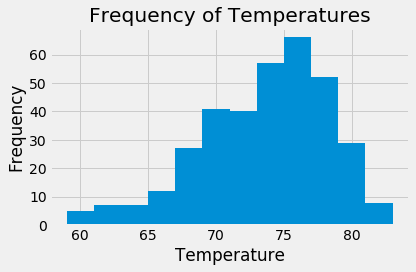

In [122]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = session.query(Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime(Measurement.date) > cutoff).all()

# Add query results to dataframe
df_tobs = pd.DataFrame(query, columns = ['tobs'])

# Create histogram
plt.hist(df_tobs['tobs'], bins = 12)
plt.title('Frequency of Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [71]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [73]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [74]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [75]:
# Plot the daily normals as an area plot with `stacked=False`
